In [2]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -r requirements.txt

/usr/bin/sh: 1: pip: not found


## Non equilibrium VAE - Experiments

In [3]:
from utils.data import make_dataloaders, save_model, DotDict
from models.VAE import VanillaVAE, IWAE, NeqVAE, FlowVAE

import matplotlib.pyplot as plt
import torch
import numpy as np

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = make_dataloaders("fashionmnist", 32, device)

### Very simple batched training loop

In [3]:
vae = VanillaVAE(latent_dim = 4)
vae.to(device)
losses = []
optim = vae.get_optimizer()

for epoch in range(2):
    for batch in train_loader:
        optim.zero_grad()
        loss, x_hat, z, BCE = vae.step(batch)
        losses.append(loss.item())
        loss.backward()
        optim.step()

In [4]:
val_losses = []
with torch.no_grad():
    for batch in val_loader:
        loss, _, _, _ = vae.step(batch)
        val_losses.append(loss.item())
np.mean(val_losses)

253.55210086712822

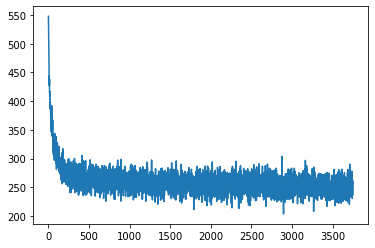

In [5]:
plt.plot(losses);

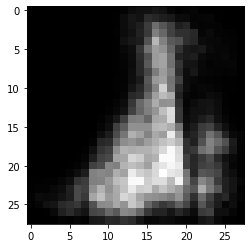

In [6]:
img = vae(torch.randn(1,4).to(device)).view(28,28).detach().numpy()
plt.imshow(img, cmap="gray");

In [12]:
val_set = torch.Tensor().to(device)
for batch in val_loader:
    val_set=torch.cat((val_set, batch), 0)
print(val_set.shape)

torch.Size([10000, 784])


In [8]:
vae.importance_estimate(1000, val_set[:100,].view(-1, 28*28)).mean()

tensor(-242.2014)

In [9]:
args_ais = DotDict()
args_ais.name = 'LeapFrog'
args_ais.estimation = True
args_ais.h = 0.01
args_ais.N_LF = 1

In [10]:
vae.ais_estimate(1000, args = args_ais, K=10, dataset = val_set[:100,].view(-1, 28*28)).mean()

tensor(-242.2249, grad_fn=<MeanBackward0>)

In [11]:
args = DotDict()
args.h = 0.01 ###should be prop to sigma/dim ? 
args.gamma = -1.
args.name = 'DampedHamiltonian'# so far implemented : 'LeapFrog', 'DampedHamiltonian', 'Identity'
dim = 4
K = 3
#a, a_string = torch.tensor(np.exp(-1.*np.arange(K)*dim*args.gamma*args.h)), 'exp(-dim*gamma*h*range(K))'
a, a_string  = torch.ones(K), 'ones(K)'
args.estimation = True

In [ ]:
vae.neq_estimate(50, args = args, a=a, dataset = val_set[:100,].view(-1, 28*28)).mean()

### Easy loading and saving

In [ ]:
import os
if not os.path.exists("./checkpoints"):
    os.mkdir("./checkpoints")

In [ ]:
torch.save(vae, "./checkpoints/vae.ckpt")

In [ ]:
vae = torch.load("./checkpoints/vae.ckpt")
vae.to(device)

## IWAE

In [7]:
iwae = IWAE(latent_dim=2, num_samples=5)
iwae.to(device)

IWAE(
  (l1_enc): Linear(in_features=784, out_features=256, bias=True)
  (l2_enc): Linear(in_features=256, out_features=4, bias=True)
  (l1_dec): Linear(in_features=2, out_features=256, bias=True)
  (l2_dec): Linear(in_features=256, out_features=784, bias=True)
)

In [8]:
losses = []
optim = iwae.get_optimizer()

for epoch in range(1):
    for batch in train_loader:
        optim.zero_grad()
        loss, x_hat, z, BCE = iwae.step(batch)
        losses.append(loss.item())
        loss.backward()
        optim.step()

In [9]:
val_losses = []
with torch.no_grad():
    for batch in val_loader:
        loss, _, _, _ = iwae.step(batch)
        val_losses.append(loss.item())
np.mean(val_losses)

268.59833114672773

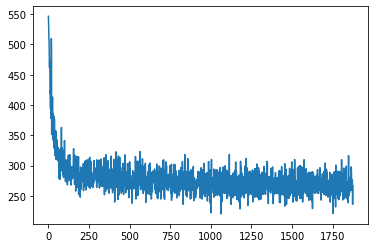

In [10]:
plt.plot(losses);

## Flow VAE

In [ ]:
flowVAE = FlowVAE(num_flows=2, latent_dim=4)
flowVAE.to(device)

In [ ]:
losses = []
optim = flowVAE.get_optimizer()

for epoch in range(5):
    for batch in train_loader:
        optim.zero_grad()
        loss, x_hat, z, BCE = flowVAE.step(batch)
        losses.append(loss.item())
        loss.backward()
        optim.step()

In [ ]:
val_losses = []
with torch.no_grad():
    for batch in val_loader:
        loss, _, _, _ = flowVAE.step(batch)
        val_losses.append(loss.item())
np.mean(val_losses)

In [ ]:
torch.logsumexp(-torch.tensor(val_losses), dim=-1) - torch.log(torch.tensor(1.*len(val_losses)))

In [ ]:
plt.plot(losses);

In [ ]:
img = flowVAE(torch.randn(1,4).to(device)).view(28,28).detach().numpy()
plt.imshow(img, cmap="gray");

## NeqVAE Hamiltonian

In [7]:
args = DotDict()
args.h = 0.1
args.gamma = 0.1
args.name = 'DampedHamiltonian'# so far implemented : 'LeapFrog', 'DampedHamiltonian', 'Identity'
K = 5
a = torch.ones(K)

In [8]:
neqvae = NeqVAE(latent_dim = 2, transformation_params = args, a = a)
neqvae.to(device)

NeqVAE(
  (net): SimpleNN(
    (l1_enc): Linear(in_features=784, out_features=256, bias=True)
    (l2_enc): Linear(in_features=256, out_features=4, bias=True)
    (l1_dec): Linear(in_features=2, out_features=256, bias=True)
    (l2_dec): Linear(in_features=256, out_features=784, bias=True)
  )
  (transformation): DampedHamiltonian()
)

In [9]:
losses = []
elbo = []
optim = neqvae.get_optimizer()
clipping_value=0.1

In [ ]:
for epoch in range(1):
    for batch in train_loader:
        optim.zero_grad()
        loss, x_hat, z, BCE = neqvae.step(batch)
        losses.append(loss.item())
        elbo.append(BCE.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(neqvae.parameters(), clipping_value)
        optim.step()
        neqvae.zero_grad()

In [ ]:
torch.logsumexp(torch.tensor(elbo), dim=-1) - torch.log(torch.tensor(1.*len(elbo)))

In [13]:
neqvae.neq_estimate(50, args = args, a=a, logvar_p = torch.zeros(1), logvar_p_transfo = torch.zeros(1), dataset = val_set[:100,].view(-1, 28*28)).mean()

tensor(-330.4888, grad_fn=<MeanBackward0>)

(0.0, -500.0)

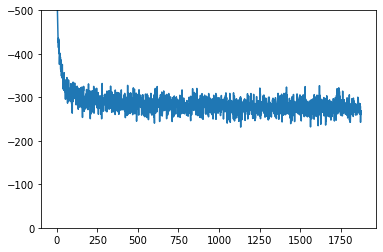

In [15]:
plt.plot(elbo)
plt.ylim(-0,-500)

In [ ]:
img = neqvae(torch.randn(1,2).to(device)).view(28,28).detach().numpy()
plt.imshow(img, cmap="gray");